#### Importing necessary libraries

In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes  import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [4]:
# We can see there aren't any NaN values in the data
data.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

#### Data Visualization and finding correlation between the feature and extracting features that affect the target feature

<AxesSubplot:>

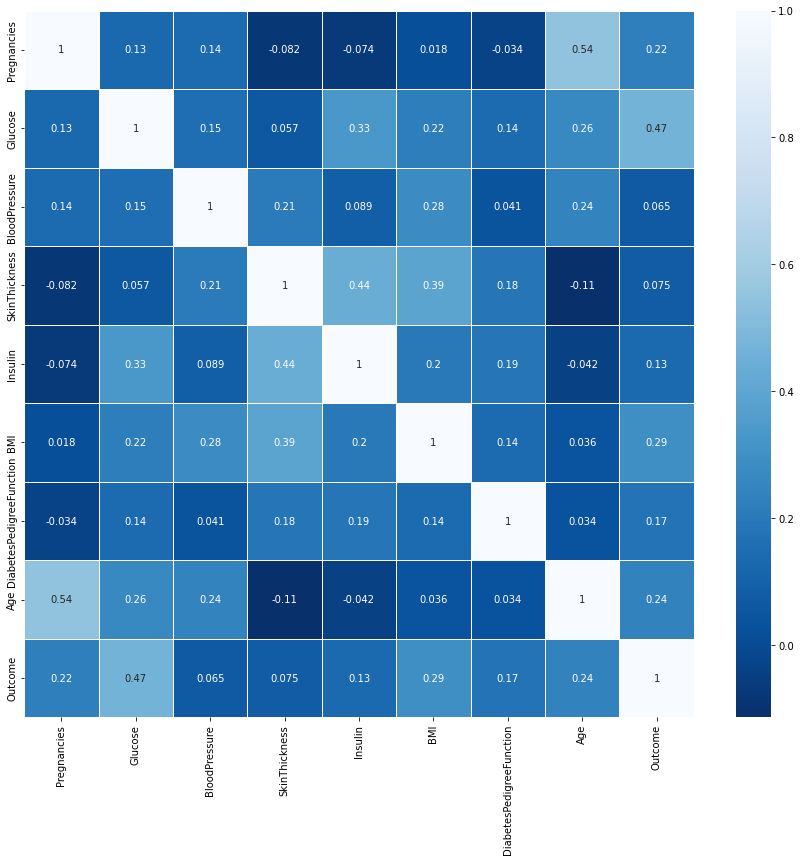

In [5]:
# Visualizing the feature correlation heatmap to get the features that affect the Dependent feature
plt.figure(figsize=(15, 13))
sns.heatmap(data.corr(), annot=True, linewidth=0.5, cmap=plt.cm.Blues_r)

In [6]:
# Just a check to get the mean of correlation of each feature with other features
for feature in data.corr():
    print(f"{feature} : {data.corr()[feature].mean()}")

Pregnancies : 0.20732600658970218
Glucose : 0.3065819273494316
BloodPressure : 0.24642689150041935
SkinThickness : 0.23967688571955925
Insulin : 0.25053926998573994
BMI : 0.28673057721896766
DiabetesPedigreeFunction : 0.20690337861677657
Age : 0.2443788270110238
Outcome : 0.29597142322424036


In [7]:
# To get a feature list that has correlation threshold greater than 0.45(Selecting 
# any one feature out of two if both the features are highly correlated with each other)
corr_df = data.corr().drop("Outcome", axis=1)
highly_corr_features = set()
for i in range(len(corr_df.columns)):
    for j in range(i):
        if abs(corr_df.iloc[i, j]) > 0.45:
            highly_corr_features.add(corr_df.columns[i])
highly_corr_features

{'Age'}

In [8]:
# Dropping highly correlated features
data.drop(highly_corr_features, axis=1, inplace=True)
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Outcome
0,6,148,72,35,0,33.6,0.627,1
1,1,85,66,29,0,26.6,0.351,0
2,8,183,64,0,0,23.3,0.672,1
3,1,89,66,23,94,28.1,0.167,0
4,0,137,40,35,168,43.1,2.288,1


In [9]:
# Function for plotting histogram and probplot(Graph that shows whether 
# the given data feature is normally distributed or not)
def plot_hist_prob(df):
    plt.figure(figsize=(18, 15))
    for i in range(len(df.columns)):
        plt.subplot(2, 4, i+1)
        plt.hist(df[df.columns[i]], bins=100)
        plt.title(df.columns[i])
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(18, 15))
    for i in range(len(df.columns)):
        plt.subplot(2, 4, i+1)
        stats.probplot(df[df.columns[i]], dist="norm", plot=plt)
        plt.title(df.columns[i])
    plt.tight_layout()
    plt.show()

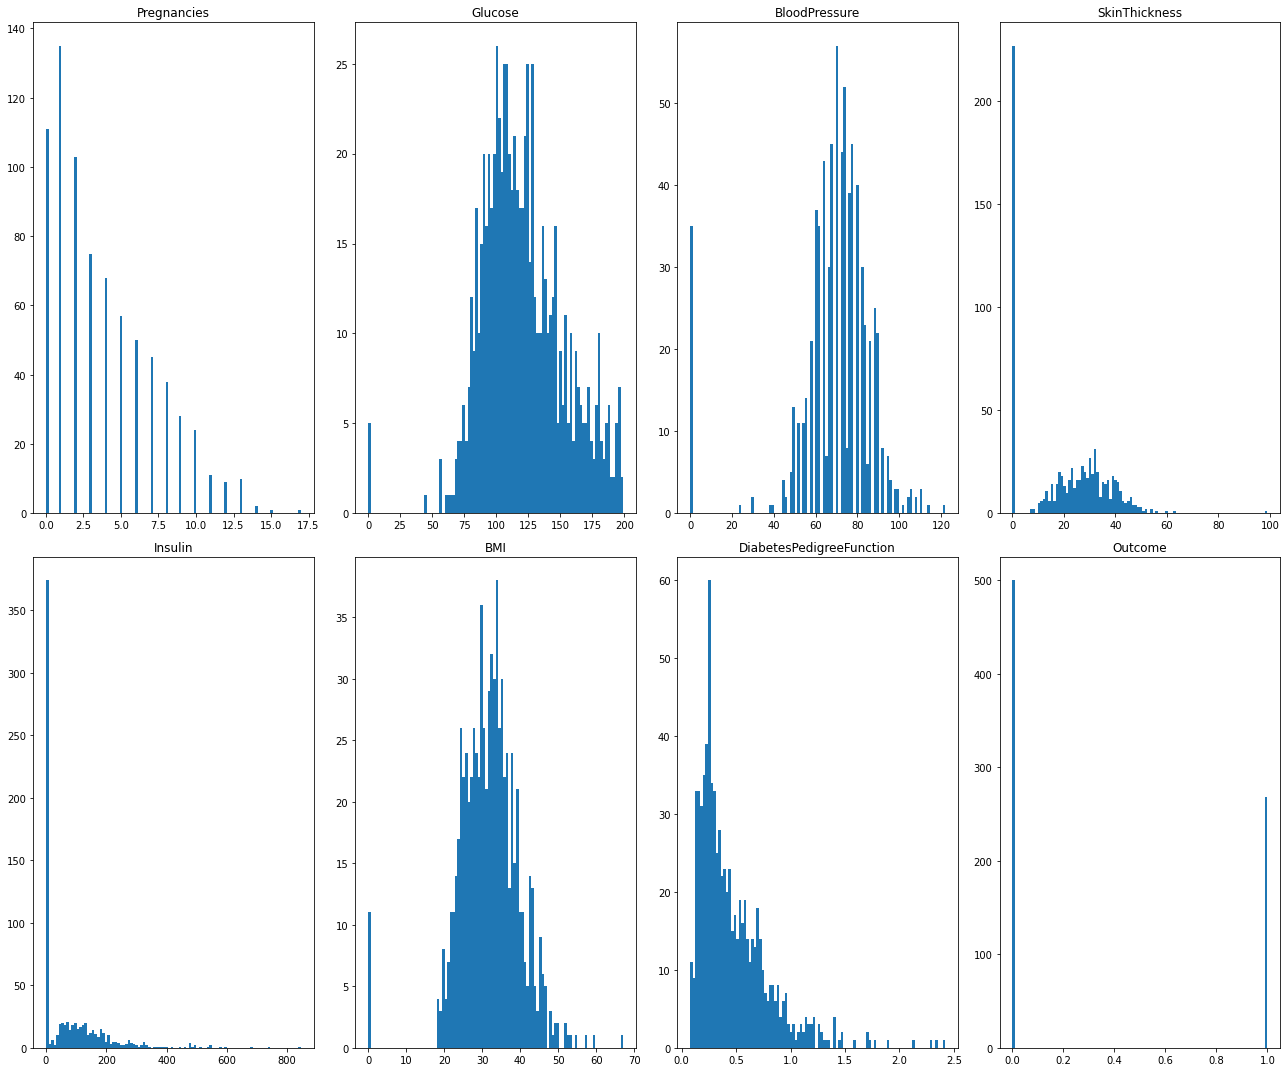

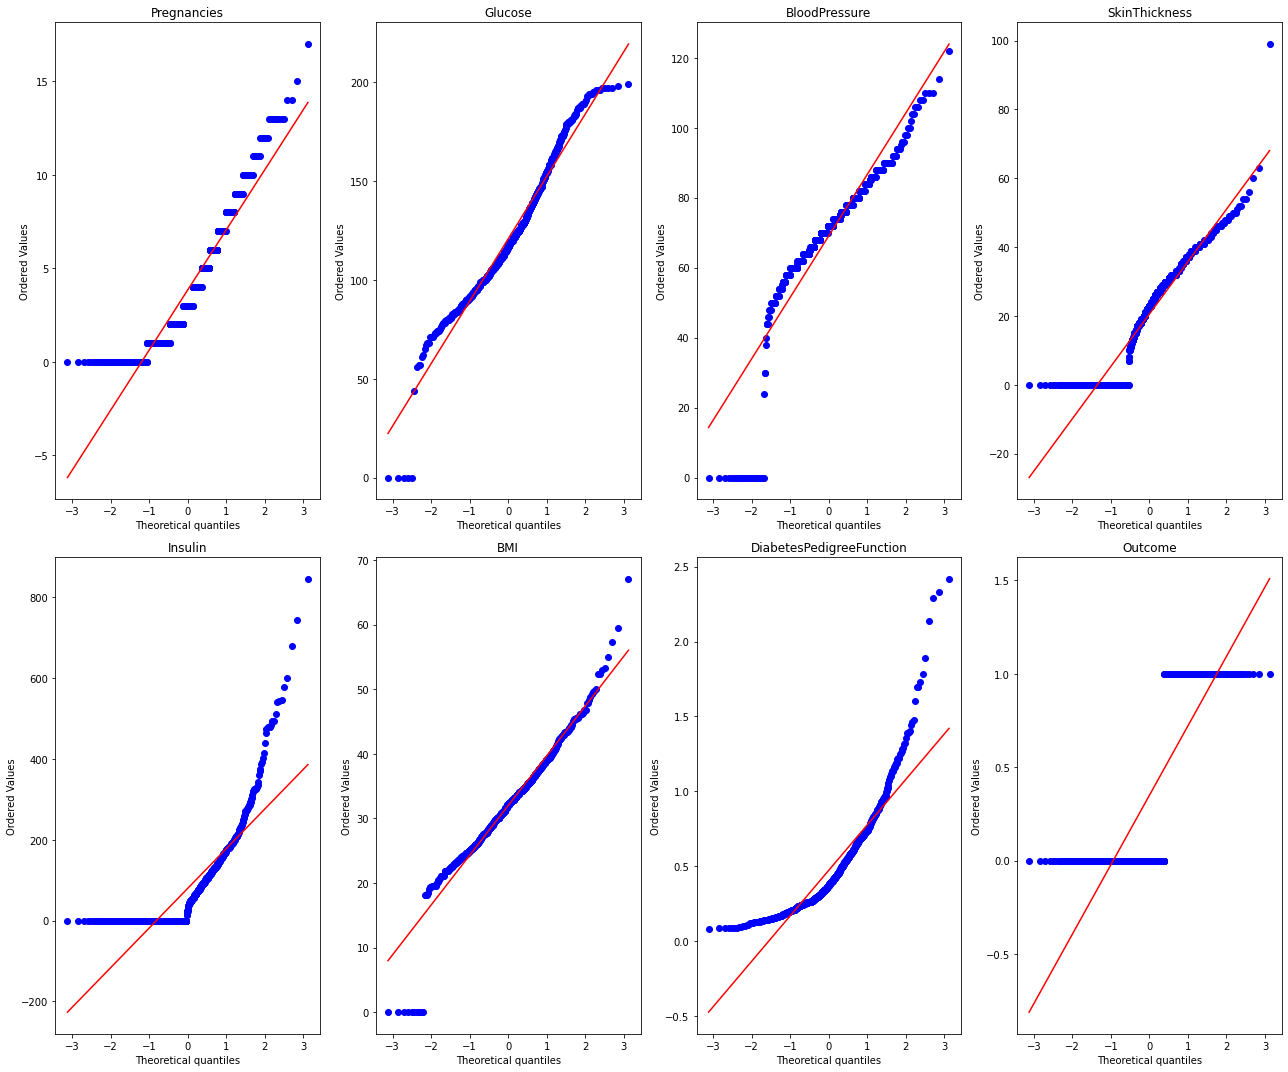

In [10]:
plot_hist_prob(data)

In [11]:
# Making a copy of data and replacing all the 0 from all the features 
# with mean of that particular feature(as boxcox() transformation requires strict positive
# values neither negative nor 0)
transformed_df = data.copy()
for feature in transformed_df.drop(["Outcome", "Pregnancies"], axis=1):
    transformed_df[feature] = transformed_df[feature].mask(transformed_df[feature] == 0).fillna(transformed_df[feature].mean())
transformed_df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Outcome
0,6,148.0,72.000000,35.000000,79.799479,33.600000,0.627,1
1,1,85.0,66.000000,29.000000,79.799479,26.600000,0.351,0
2,8,183.0,64.000000,20.536458,79.799479,23.300000,0.672,1
3,1,89.0,66.000000,23.000000,94.000000,28.100000,0.167,0
4,0,137.0,40.000000,35.000000,168.000000,43.100000,2.288,1
5,5,116.0,74.000000,20.536458,79.799479,25.600000,0.201,0
6,3,78.0,50.000000,32.000000,88.000000,31.000000,0.248,1
7,10,115.0,69.105469,20.536458,79.799479,35.300000,0.134,0
8,2,197.0,70.000000,45.000000,543.000000,30.500000,0.158,1
9,8,125.0,96.000000,20.536458,79.799479,31.992578,0.232,1


In [12]:
# Using boxcox() tranformation for transforming data so that the data gets normally distributed
for feature in transformed_df.drop(["Pregnancies", "Outcome"], axis=1):
    transformed_df[feature], params = boxcox(transformed_df[feature])
transformed_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Outcome
0,6,6.428897,44.847509,3.776155,2.422353,4.123930,-0.474866,1
1,1,5.552554,41.530105,3.564938,2.422353,3.808150,-1.088080,0
2,8,6.777007,40.415071,3.180785,2.422353,3.631991,-0.403329,1
3,1,5.623444,41.530105,3.306410,2.464626,3.881716,-1.912132,0
4,0,6.304011,26.590348,3.776155,2.598647,4.467784,0.803134,1


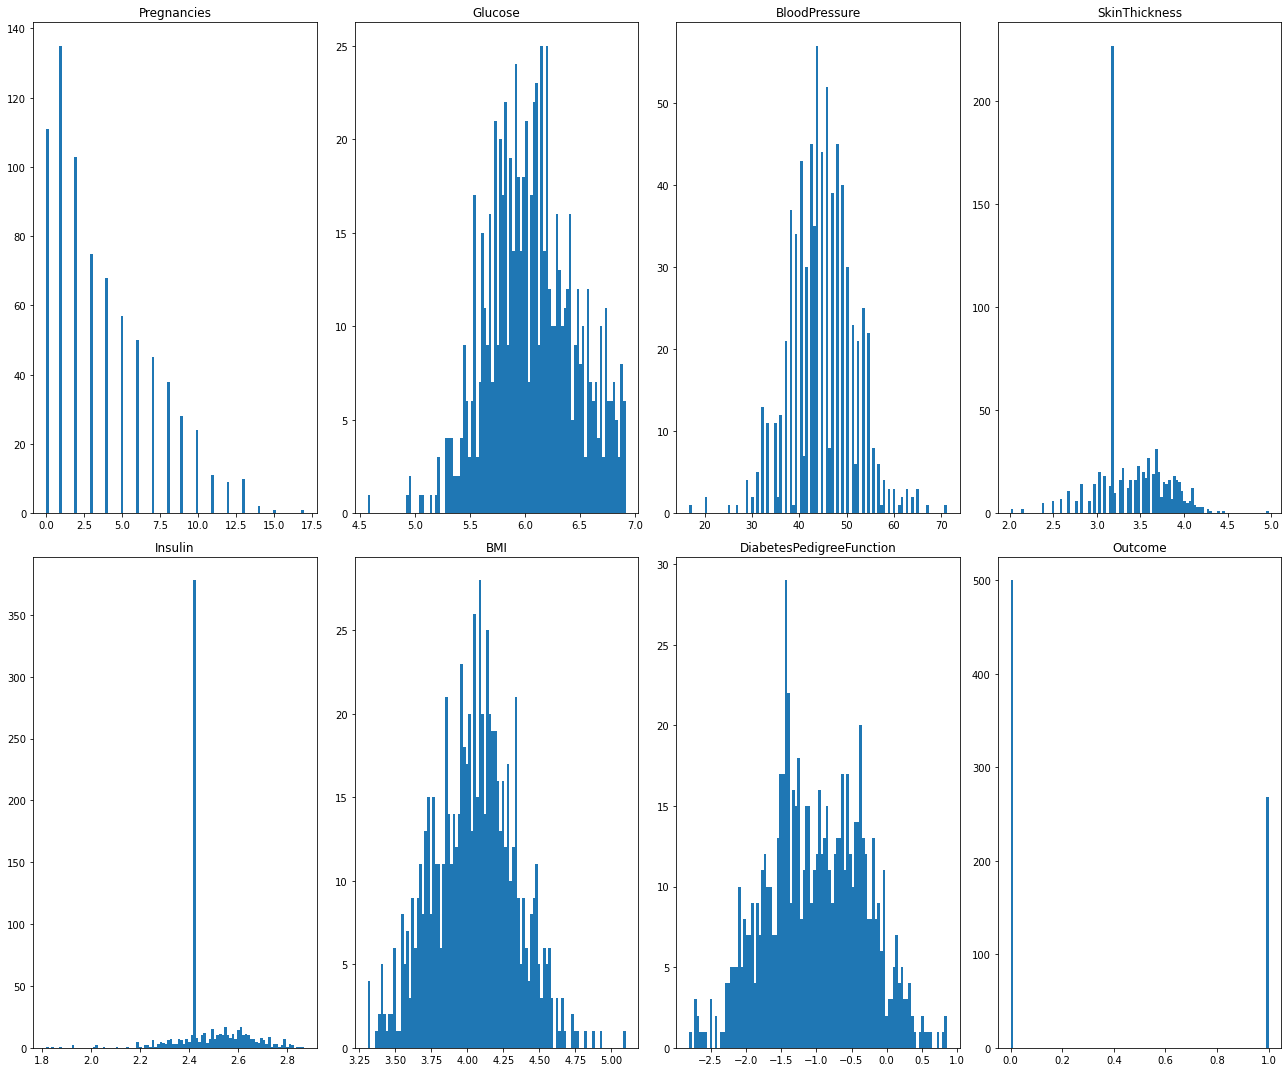

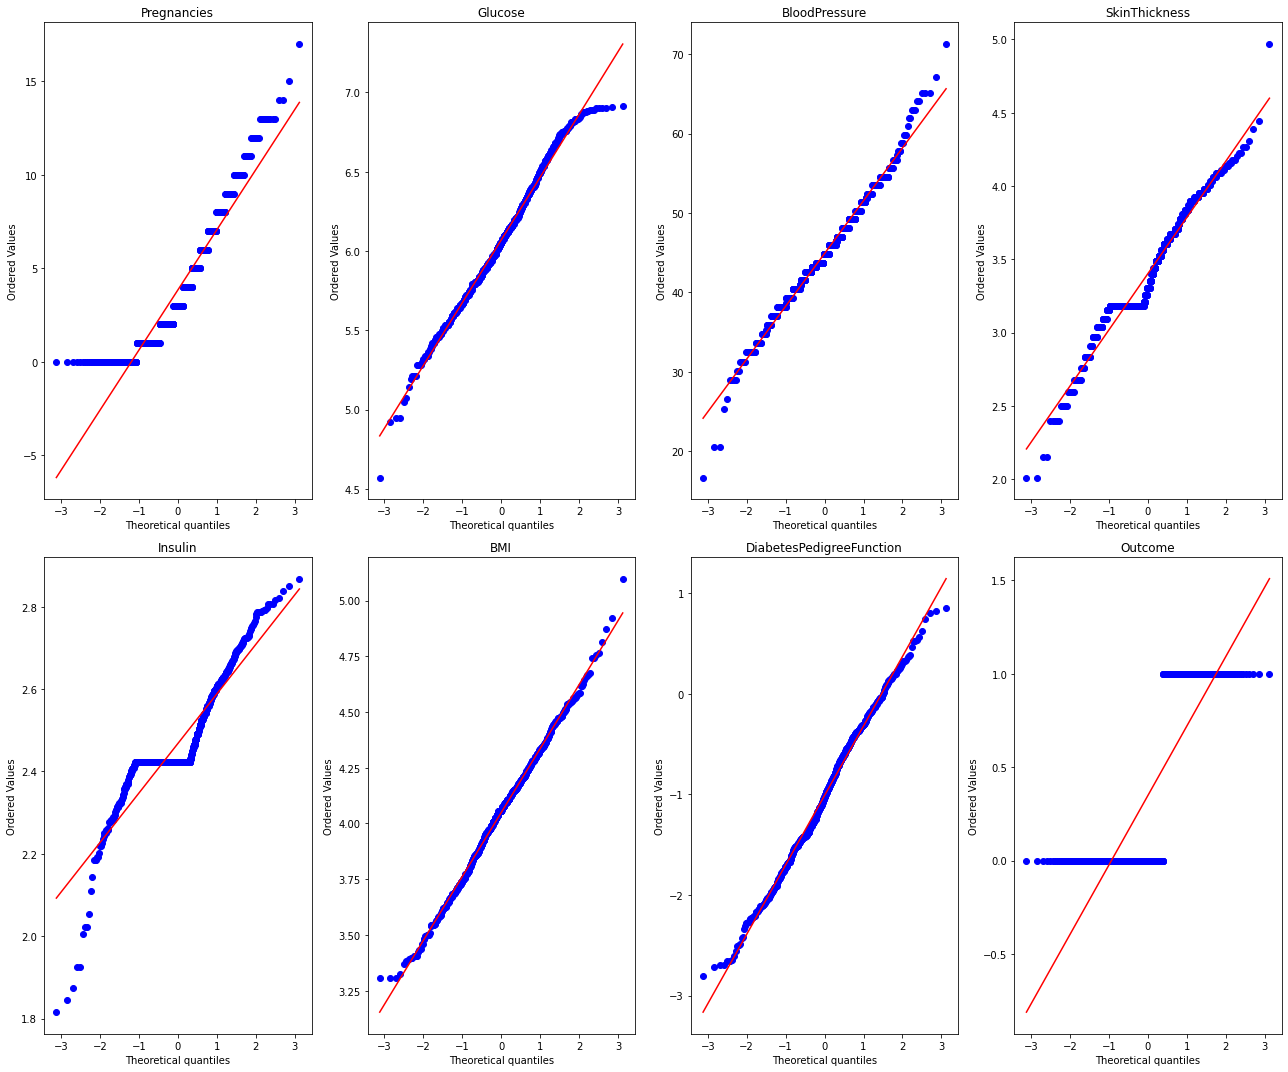

In [13]:
plot_hist_prob(transformed_df)

#### Preparing and splitting the data

In [14]:
X = np.array(transformed_df.drop(['Outcome'], axis=1))
y = np.array(transformed_df['Outcome'])

In [15]:
# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(614, 7) (614,)
(154, 7) (154,)


In [16]:
# Scaling the data between -1 and 1
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_train_scaled

array([[-1.1328442 ,  1.24218175,  0.29835825, ...,  0.09366789,
         2.53277662,  1.09369357],
       [-0.54212969, -1.20149433, -0.26637371, ..., -0.33958948,
        -0.42789041,  1.12082727],
       [-1.1328442 ,  0.56877028, -0.35763907, ...,  0.77929315,
        -1.14542404, -1.54356485],
       ...,
       [-0.24677243, -0.08898764,  0.13530591, ...,  0.1835065 ,
        -0.87116349, -2.03551181],
       [-0.83748694, -1.15788711, -3.65966846, ...,  0.07499607,
         2.69887337,  0.45177078],
       [ 0.34394208, -0.82429881,  0.13530591, ..., -0.69626559,
         0.28837473,  1.49486319]])

In [17]:
X_test_scaled = sc.transform(X_test)
X_test_scaled

array([[ 0.04858483,  1.03756097, -0.02836448, ...,  0.50768494,
        -0.04987254, -0.14429947],
       [-0.54212969, -0.22635759,  1.10496321, ...,  0.9061761 ,
         0.93115394, -0.65089682],
       [-0.83748694,  0.51020725, -1.53290197, ..., -0.33958948,
        -0.80043705,  0.94509167],
       ...,
       [ 1.23001385, -1.29008396, -1.44765005, ..., -0.33958948,
        -1.22111221, -1.62795591],
       [ 0.34394208,  0.36029858,  0.78398709, ..., -0.33958948,
         1.01869943,  1.43361829],
       [-0.24677243, -0.70564999, -1.53290197, ..., -0.19261244,
        -0.99732773, -1.41952153]])

#### Trying multiple classification algorithms(RandomForest, SVM, Naive Bayes) and getting their accuracy

In [18]:
rf = RandomForestClassifier(n_estimators=300, min_samples_split=50)
svc = SVC(kernel='linear', degree=0, decision_function_shape='ovo')
nb = GaussianNB()
lr = LogisticRegression(solver = "newton-cg", penalty = 'l2', max_iter=100)
classifiers = [rf, svc, nb, lr]

accuracies = []
for clf in classifiers:
    clf.fit(X_train,y_train)
    acc = clf.score(X_test, y_test)
    accuracies.append(acc)

accuracies

[0.7597402597402597,
 0.7467532467532467,
 0.7532467532467533,
 0.7532467532467533]

##### Using RandomForest as it gave better accuracy than others

In [19]:
clf = RandomForestClassifier(n_estimators=300, min_samples_split=50)
clf.fit(X_train_scaled, y_train)
acccuracy = clf.score(X_test_scaled, y_test)
acccuracy

0.7727272727272727

#### Saving the model for future development

In [20]:
pickle.dump(clf, open("classifier.pkl", "wb"))

#### To load the saved model and predict the result

In [21]:
clf = pickle.load(open("classifier.pkl", 'rb'))
result = clf.predict(X_test)
result

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])